In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.var import VAR

ModuleNotFoundError: No module named 'sktime'

In [25]:
df = pd.read_csv('../data/fresno_eda.csv', index_col='datetime', parse_dates=True)
df = pd.DataFrame(df['precip'])

In [26]:
df.head()

,precip
datetime,
1992-01-01,0.000
1992-01-02,0.000
1992-01-03,0.083
1992-01-04,0.000
1992-01-05,1.016


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10959 entries, 1992-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  10959 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


In [56]:
df_week = df.resample('W').mean()
df_month = df.resample('M').mean()

In [57]:
df_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1566 entries, 1992-01-05 to 2022-01-02
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  1566 non-null   float64
dtypes: float64(1)
memory usage: 24.5 KB


In [58]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 1992-01-31 to 2022-01-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  361 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


In [59]:
df_week.isnull().sum(), df_month.isnull().sum()

(precip    0
 dtype: int64,
 precip    0
 dtype: int64)

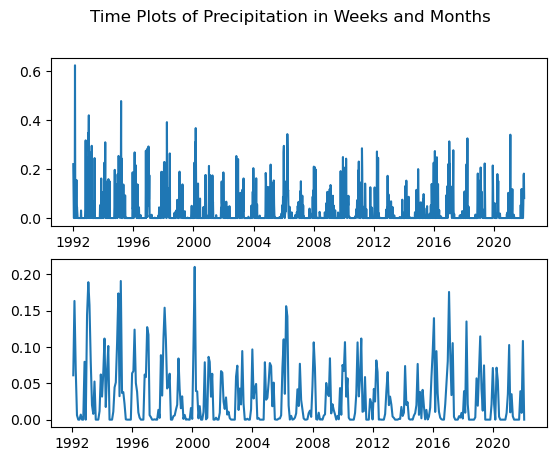

In [60]:
fig, ax = plt.subplots(2)
fig.suptitle('Time Plots of Precipitation in Weeks and Months')
ax[0].plot(df_week)
ax[1].plot(df_month)

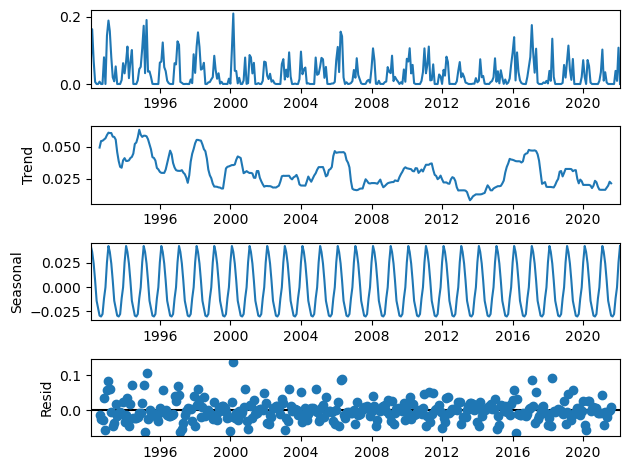

In [61]:

# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df_month)

# Plot the decomposed time series.
decomp.plot();

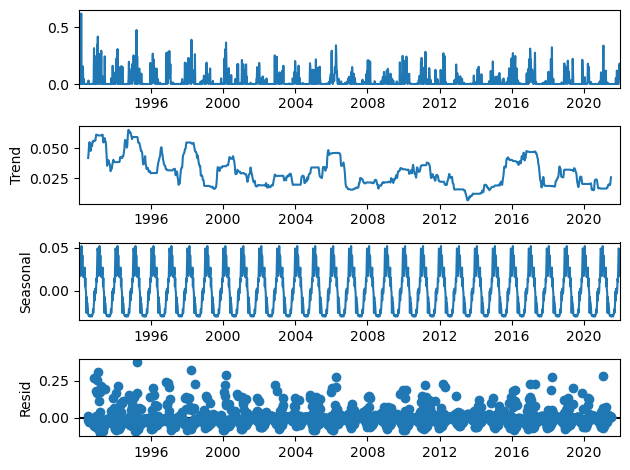

In [38]:

# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df_week)

# Plot the decomposed time series.
decomp.plot();

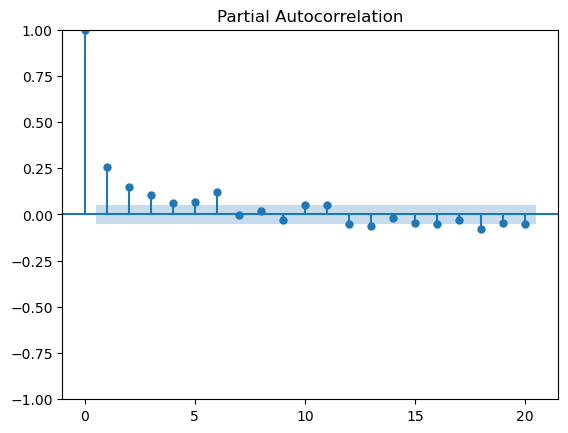

In [39]:
plot_pacf(df_week, lags=20, method='ywm');

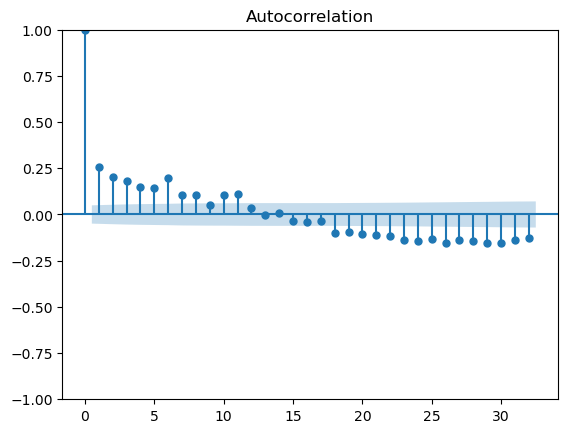

In [40]:
plot_acf(df_week);

In [45]:
train = df_week.loc[:'2016-01-01']

In [44]:
test = df_week.loc['2016-01-02':]

In [46]:
train.shape, test.shape

((1252, 1), (314, 1))

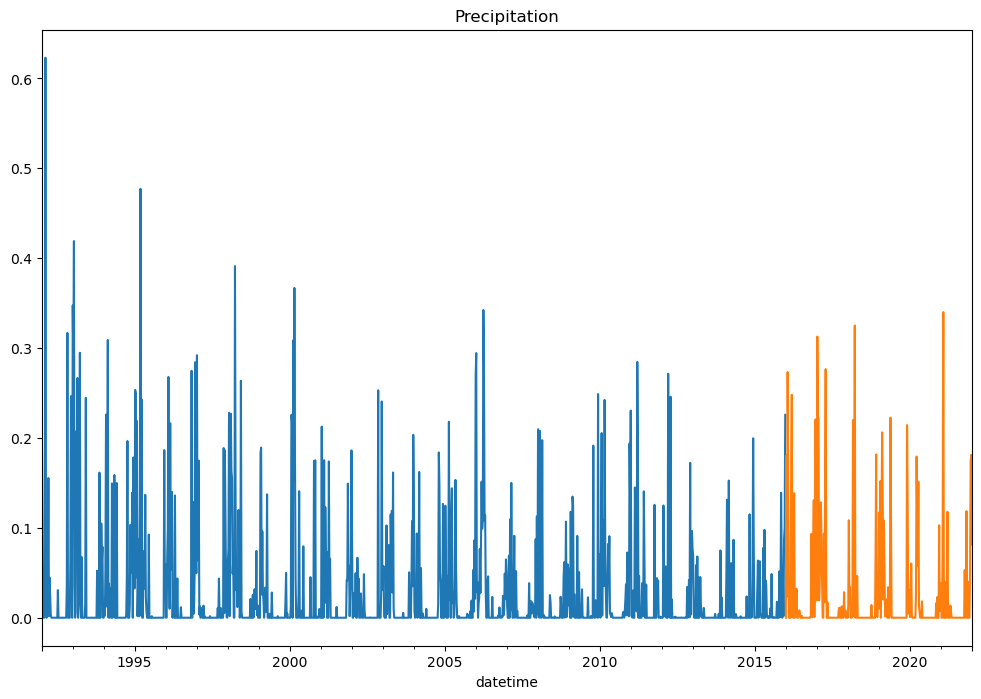

In [47]:
train['precip'].plot()
test['precip'].plot(figsize = (12, 8), title = 'Precipitation');

In [62]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [64]:
interpret_dftest(adfuller(df_month))

Test Statistic    -3.848855
p-value            0.002445
Lag Used          12.000000
dtype: float64

In [48]:
df_preds = test.copy()

In [49]:
train.index.freq = 'W'

In [50]:
train

,precip
datetime,
1992-01-05,0.219800
1992-01-12,0.113286
1992-01-19,0.000000
1992-01-26,0.000000
1992-02-02,0.000000
...,...
2015-11-29,0.046714
2015-12-06,0.001857
2015-12-13,0.087286


In [51]:
hw = ExponentialSmoothing(train['precip'], trend='add', seasonal='add').fit()

In [52]:
hw.summary()

Dep. Variable:,precip,No. Observations:,1252
Model:,ExponentialSmoothing,SSE,4.436
Optimized:,True,AIC,-6952.826
Trend:,Additive,BIC,-6665.407
Seasonal:,Additive,AICC,-6947.090
Seasonal Periods:,52,Date:,"Wed, 23 Aug 2023"
Box-Cox:,False,Time:,18:27:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.2456e-09,beta,True


In [53]:
df_preds['hw'] = hw.forecast(len(test))

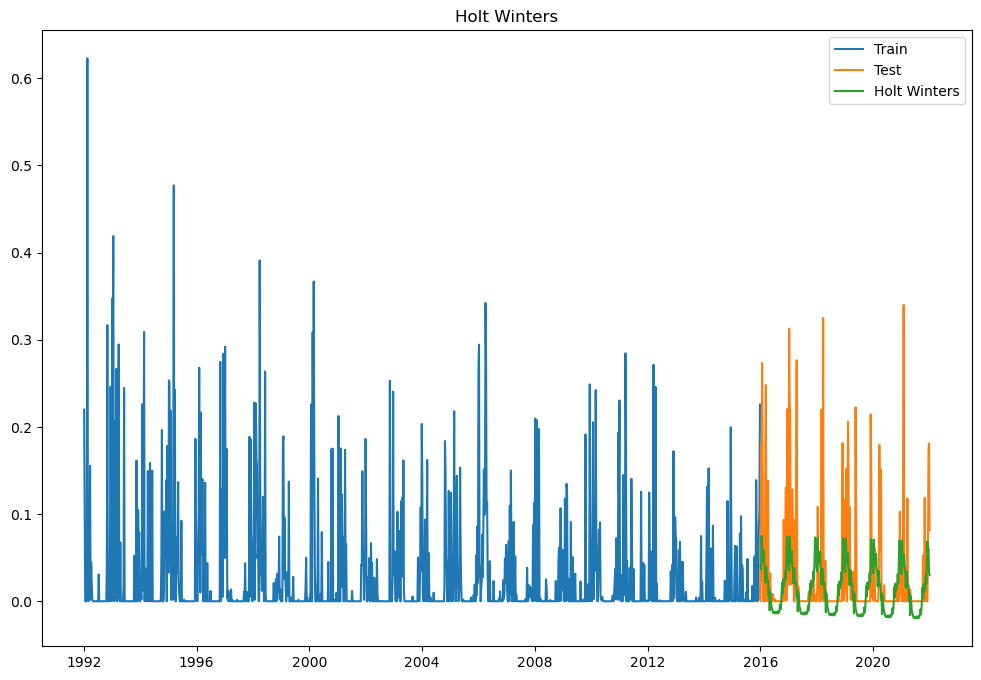

In [54]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train['precip'], label = 'Train')
plt.plot(test.index, test['precip'], label = 'Test')
plt.plot(df_preds.index, df_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.title('Holt Winters');